In [1]:
from scipy.fft import fft, ifft

This notebook follows the tutorial found here https://www.youtube.com/watch?v=sHWKN5dakPw


In [2]:
### Import Dependancies

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

import random
import math
import time

from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')

from google.colab import files
from google.colab import drive
drive.mount('/Drive')

from scipy.fft import fft, ifft

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /Drive


Import Data Set


In [3]:
whoURL = 'https://covid19.who.int/WHO-COVID-19-global-data.csv'
who_data = pd.read_csv(whoURL)

In [4]:
who_data.tail(5)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
28847,2020-07-13,ZW,Zimbabwe,AFRO,3,985,0,18
28848,2020-07-14,ZW,Zimbabwe,AFRO,49,1034,1,19
28849,2020-07-15,ZW,Zimbabwe,AFRO,30,1064,1,20
28850,2020-07-16,ZW,Zimbabwe,AFRO,25,1089,0,20
28851,2020-07-17,ZW,Zimbabwe,AFRO,273,1362,3,23


In [5]:
# Drop rows that have missing values
print(who_data.shape)
who_data.dropna(inplace=True)
print(who_data.shape)

(28852, 8)
(28726, 8)


In [6]:
# reconfigure the data so we have just deaths
cumulative_deaths = who_data.filter(['Date_reported', ' Cumulative_deaths'], axis = 1)
cumulative_deaths = cumulative_deaths.groupby('Date_reported', as_index=False).sum()
cumulative_deaths.head(3)

,Date_reported,Cumulative_deaths
0,2020-01-11,1
1,2020-01-12,1
2,2020-01-13,1


In [7]:
# reconfigure the data so we have just cases
cumulative_cases = who_data.filter(['Date_reported', ' Cumulative_cases'], axis = 1)
cumulative_cases = cumulative_cases.groupby('Date_reported', as_index=False).sum()
cumulative_cases.tail(3)

,Date_reported,Cumulative_cases
186,2020-07-15,13151805
187,2020-07-16,13377890
188,2020-07-17,13615561


In [8]:
earliest_reported = who_data['Date_reported'].min()
earliest_reported
last_updated = who_data['Date_reported'].max()
last_updated


'2020-07-17'

In [9]:
dates = cumulative_cases['Date_reported']
dates

0      2020-01-11
1      2020-01-12
2      2020-01-13
3      2020-01-14
4      2020-01-15
          ...    
184    2020-07-13
185    2020-07-14
186    2020-07-15
187    2020-07-16
188    2020-07-17
Name: Date_reported, Length: 189, dtype: object

In [10]:
world_cases = np.array(cumulative_cases[' Cumulative_cases'])
world_cases

array([      41,       41,       42,       43,       43,       43,
             48,       65,      125,      203,      296,      450,
            583,      854,     1323,     2021,     2806,     4595,
           6076,     7836,     9846,    11961,    14559,    17391,
          20649,    24563,    28284,    31486,    34899,    37568,
          40623,    43109,    45174,    60387,    64455,    67187,
          69277,    71438,    73431,    75287,    75773,    76817,
          77926,    78942,    79566,    80392,    81316,    82685,
          84133,    85959,    87850,    90131,    92463,    94663,
          97440,   101240,   105166,   108904,   112951,   117439,
         123964,   130483,   140126,   151636,   163489,   175280,
         190104,   208533,   232509,   265401,   288849,   298185,
         331907,   391864,   422395,   478118,   519722,   582513,
         644250,   701942,   760029,   833723,   907004,   982209,
        1062266,  1142094,  1219079,  1288420,  1362610,  1445

In [11]:
total_deaths = np.array(cumulative_deaths[' Cumulative_deaths'])
total_deaths

array([     1,      1,      1,      1,      1,      1,      2,      2,
            3,      4,      6,      9,     17,     25,     41,     56,
           80,    106,    132,    170,    213,    259,    305,    362,
          426,    492,    565,    638,    724,    813,    910,   1018,
         1115,   1371,   1384,   1528,   1670,   1776,   1874,   2012,
         2130,   2250,   2363,   2464,   2628,   2711,   2772,   2815,
         2874,   2942,   2987,   3074,   3154,   3245,   3346,   3459,
         3554,   3800,   4005,   4288,   4647,   5005,   5492,   5926,
         6659,   7399,   8233,   9307,  10528,  12086,  13849,  14660,
        16709,  18989,  21380,  24247,  26945,  30330,  33771,  37172,
        40842,  45088,  50019,  54899,  61545,  67344,  72347,  77732,
        84611,  90963,  98408, 105301, 111509, 117128, 122584, 128762,
       136626, 149030, 155606, 162436, 167530, 172957, 179681, 186310,
       192604, 198451, 204823, 209614, 213648, 218898, 224785, 231088,
      

In [12]:
days_since_start = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases     = np.array(world_cases).reshape(-1, 1)
total_deaths    = np.array(total_deaths).reshape(-1, 1)

Future Forecasting


In [13]:
days_in_future  = 30  # WE WILL GO 30 DAYS INTO THE FUTURE
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates  = future_forecast[:-30]

In [14]:
start = earliest_reported
start_date = datetime.datetime.strptime(start, '%Y-%m-%d')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime( '%m/%d/%Y'))

Machine Learning

In [113]:
# Have a function to go through each country one by one and create a new .csvfile. 

def one_country(country_name, feature):
    one_country = who_data[who_data[' Country']==country_name]
    print("Processing: ", country_name.upper())
    #print(one_country)
    
    # reconfigure the data so we have just deaths
    X = one_country.filter(['Date_reported', feature], axis = 1)
    X = X.groupby('Date_reported', as_index=False).sum()
    #print(X.tail(3))
    
    y = np.array(X[feature])
    # y = fft(y)
    one_cases  = np.array(y).reshape(-1, 1)

    dates = X['Date_reported']

    days_since_start= np.array([i for i in range(len(dates))]).reshape(-1, 1)
   
    days_in_future  = 30  # WE WILL GO 30 DAYS INTO THE FUTURE
    future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
    
    adjusted_dates  = future_forecast[:-30]


    
    ### print(len(future_forecast))
    ### Split the data
    X_train_confirmed, X_test_confirmed,y_train_confirmed, y_test_confirmed = train_test_split(days_since_start, one_cases, test_size=0.35, shuffle=True)


    #building SVM Model
    kernel = ['poly', 'sigmoid', 'rbf']
    c = [0.01, 0.1, 1 ]
    gamma = [0.01, 0.1]
    epsilon = [0.01, 0.1]
    shrinking = [True, False]
    svm_grid = {'kernel':kernel, 'C':c, 'gamma':gamma, 'epsilon':epsilon, 'shrinking':shrinking}

    svm        = SVR()
    svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv = 3, n_jobs=-1, n_iter=10, return_train_score=True, verbose =1)

    svm_search.fit(X_train_confirmed, y_train_confirmed.ravel())  
    
    
    svm_search.best_params_
    svm_confirmed = svm_search.best_estimator_
    svm_pred      = svm_confirmed.predict(future_forecast)
    
    # Check against testing data

    svm_test_pred = svm_confirmed.predict(X_test_confirmed)
    plt.figure()
    plt.title(country_name.upper() + ': ' + feature + ' Test the model (y_test) (blue), Predicted (red)')
    plt.plot(svm_test_pred, color='RED') #Predicted.
    plt.plot(y_test_confirmed)   #Actual

    plt.savefig(country+feature+'test.png')

    # print ('Mean Absolute Error', mean_absolute_error(svm_test_pred, y_test_confirmed))
    # print ('Mean Squared Error ',  mean_squared_error(svm_test_pred, y_test_confirmed))
    
    plt.figure(figsize=(20, 12))
    plt.title(country_name.upper() + ": " + feature + ' (blue), Predicted (red)')
    plt.plot(adjusted_dates, one_cases)
    _ = plt.plot(future_forecast, svm_pred, linestyle='dashed', color='red') 

    score = svm_confirmed.score(X_train_confirmed, y_train_confirmed)
    print('Country: ', country, " training score: ", score)

    score = svm_confirmed.score(X_test_confirmed, y_test_confirmed)
    print('Country: ',country, " test score: ", score)
 
    with open('/Drive/My Drive/Colab Notebooks/COVID19/'+country+feature+'.png', 'w') as f:
      plt.savefig(country+feature+'.png')

    return(svm_pred)

In [114]:
worst_affected_countries = ['Brazil', 'Germany', 'India','Iran (Islamic Republic of)', 'Italy', 'Russian Federation', 'Spain', 'The United Kingdom', 'Turkey', 'United States of America' ]

Brazil
Processing:  BRAZIL
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.9min finished


Country:  Brazil  training score:  0.9912199885071401
Country:  Brazil  test score:  0.9895366885671923
Processing:  BRAZIL
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   20.9s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


Country:  Brazil  training score:  0.9922712165674772
Country:  Brazil  test score:  0.9843477985345057
Germany
Processing:  GERMANY
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.1s finished


Country:  Germany  training score:  0.6270671500753252
Country:  Germany  test score:  0.6077169143692454
Processing:  GERMANY
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 18.0min finished


Country:  Germany  training score:  0.6817282169685603
Country:  Germany  test score:  0.5456101567859472
India
Processing:  INDIA
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.7s finished


Country:  India  training score:  0.909837781636742
Country:  India  test score:  0.9254630156132728
Processing:  INDIA
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.0s finished


Country:  India  training score:  0.9486347266159549
Country:  India  test score:  0.9597167486136317
Iran (Islamic Republic of)
Processing:  IRAN (ISLAMIC REPUBLIC OF)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


Country:  Iran (Islamic Republic of)  training score:  0.8966078363462838
Country:  Iran (Islamic Republic of)  test score:  0.9072946655679626
Processing:  IRAN (ISLAMIC REPUBLIC OF)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  3.9min remaining:   26.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.8min finished


Country:  Iran (Islamic Republic of)  training score:  0.8160137946127504
Country:  Iran (Islamic Republic of)  test score:  0.8176300912558595
Italy
Processing:  ITALY
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.3s finished


Country:  Italy  training score:  0.5984232688827462
Country:  Italy  test score:  0.5785831283450468
Processing:  ITALY
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   38.8s finished


Country:  Italy  training score:  0.6353842512315108
Country:  Italy  test score:  0.6070534375389448
Russian Federation
Processing:  RUSSIAN FEDERATION
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.8s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  Russian Federation  training score:  0.9662290333761918
Country:  Russian Federation  test score:  0.970815335750375
Processing:  RUSSIAN FEDERATION
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.9min finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  Russian Federation  training score:  0.9872444684436819
Country:  Russian Federation  test score:  0.9871563459691333
Spain
Processing:  SPAIN
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  Spain  training score:  0.5494713818926695
Country:  Spain  test score:  0.4749178812496199
Processing:  SPAIN
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   27.3s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   40.5s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  Spain  training score:  0.5417343599372798
Country:  Spain  test score:  0.5701210307131666
The United Kingdom
Processing:  THE UNITED KINGDOM
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  The United Kingdom  training score:  0.7321294903444686
Country:  The United Kingdom  test score:  0.6560708444553838
Processing:  THE UNITED KINGDOM
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  The United Kingdom  training score:  0.6635362973585515
Country:  The United Kingdom  test score:  0.7846383791440709
Turkey
Processing:  TURKEY
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.0s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  Turkey  training score:  0.4580990982992415
Country:  Turkey  test score:  0.4053619113796628
Processing:  TURKEY
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.8s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  Turkey  training score:  0.6424190947962181
Country:  Turkey  test score:  0.5135934462254148
United States of America
Processing:  UNITED STATES OF AMERICA
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.0s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  United States of America  training score:  0.9562610919757332
Country:  United States of America  test score:  0.9542108198997957
Processing:  UNITED STATES OF AMERICA
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  United States of America  training score:  0.885642274240544
Country:  United States of America  test score:  0.8303786437108673


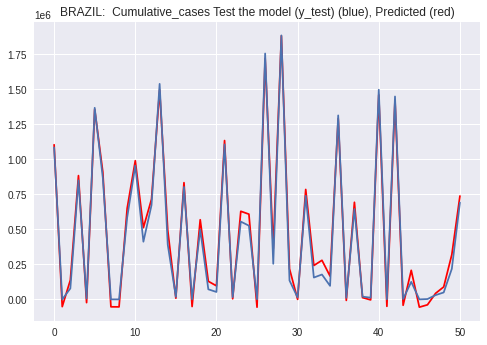

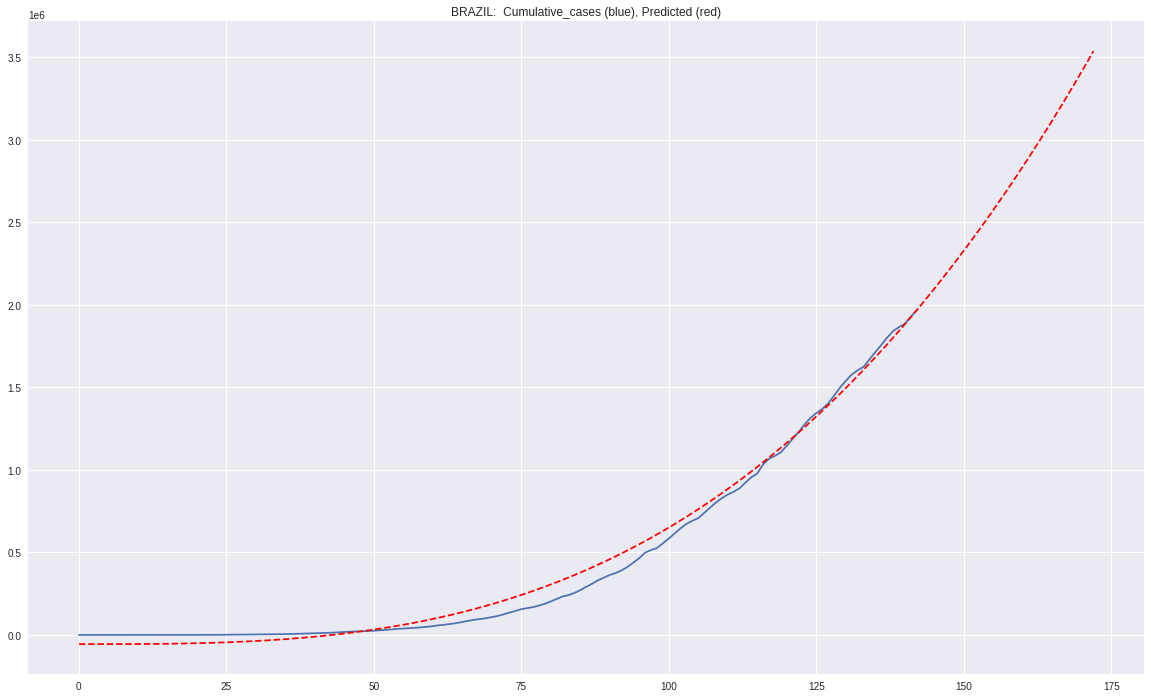

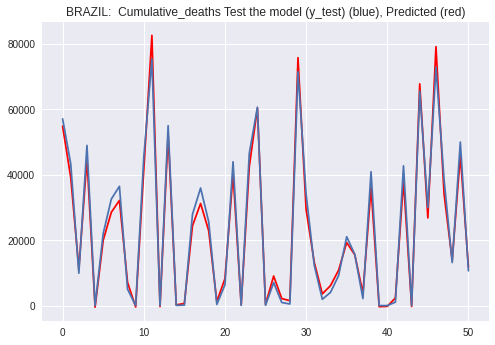

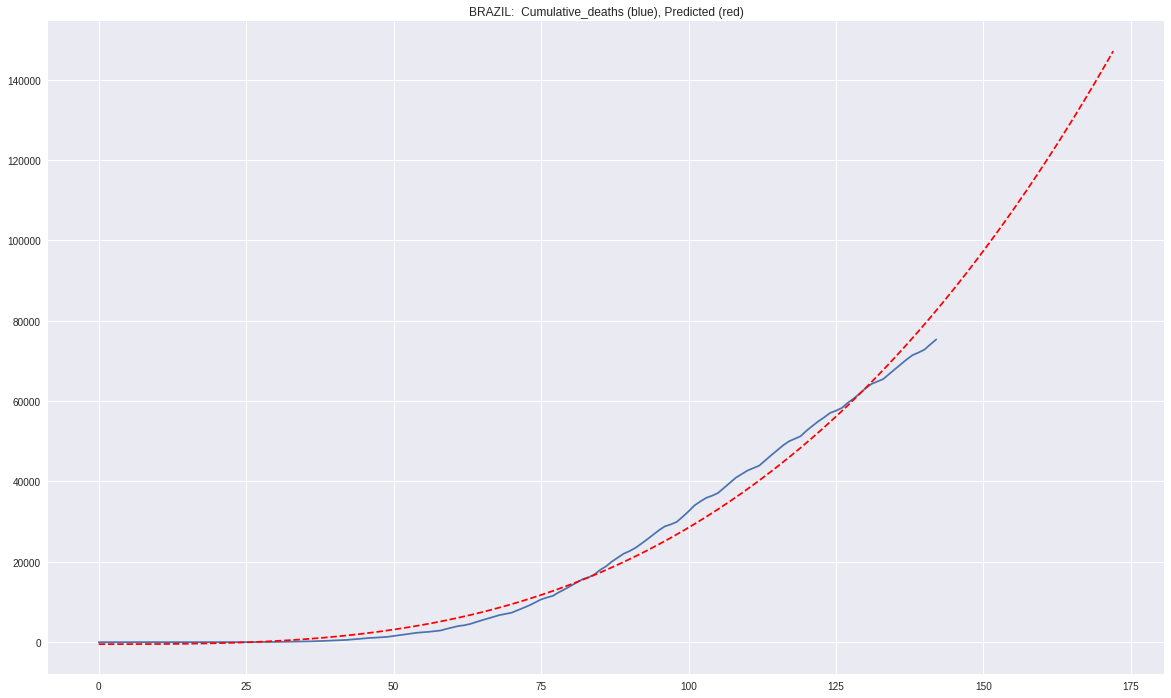

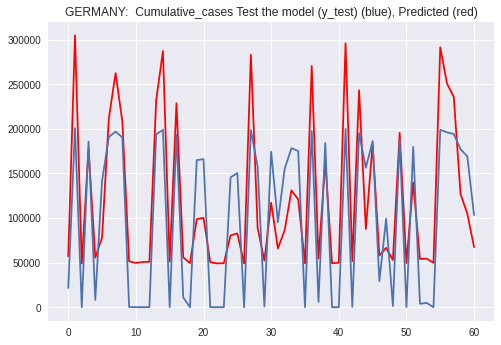

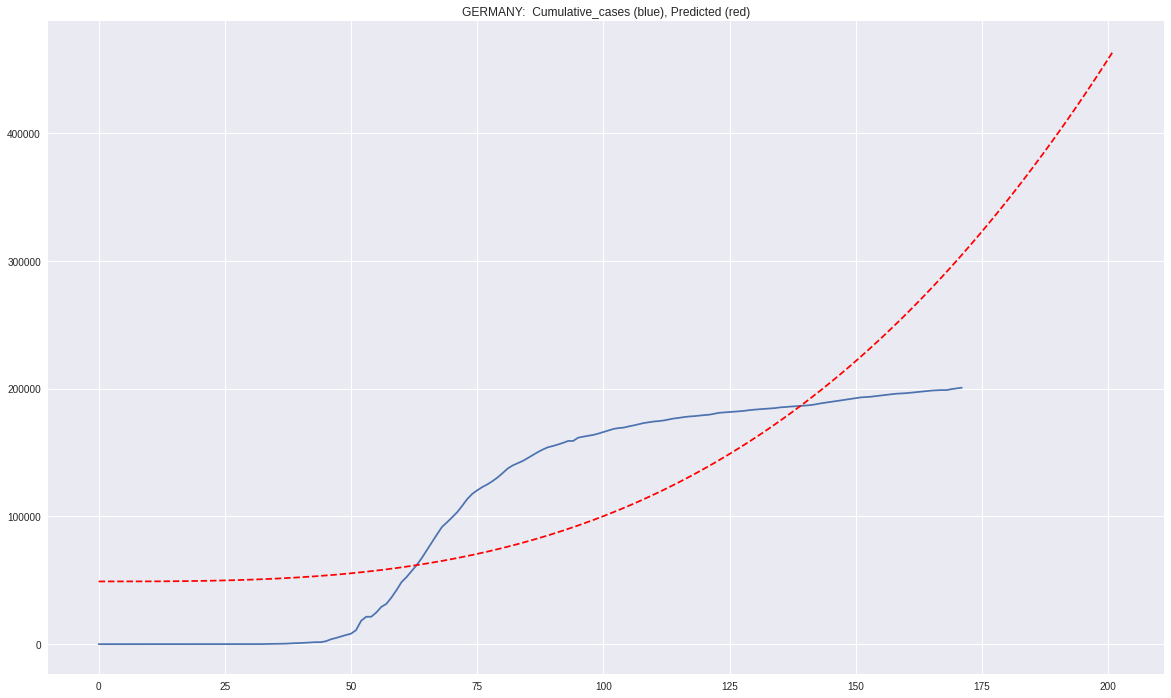

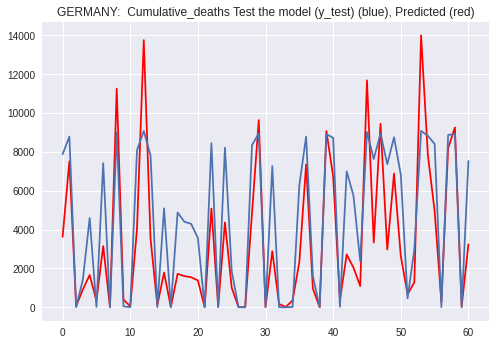

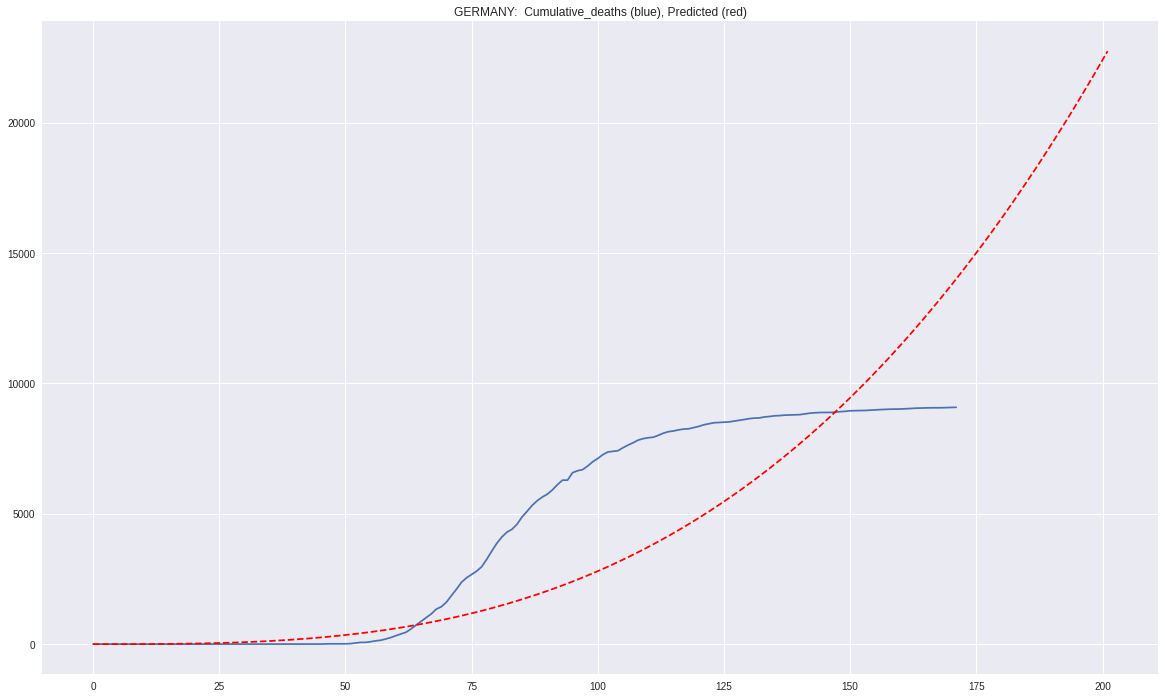

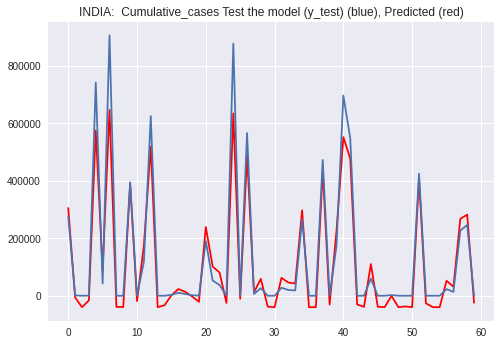

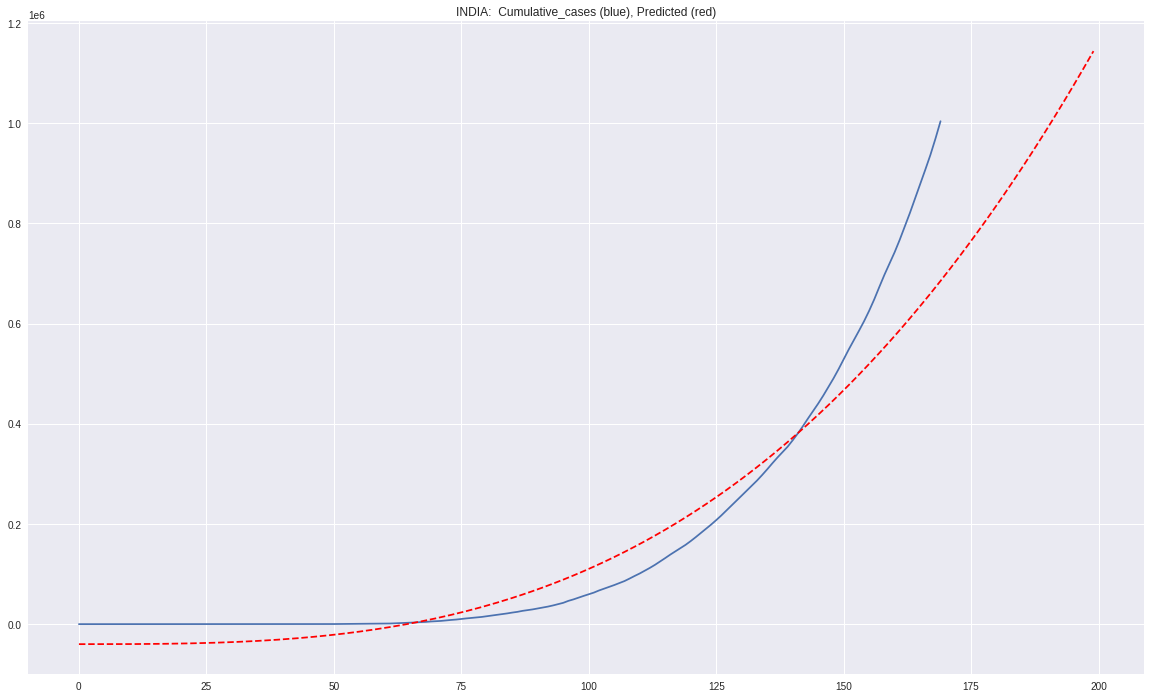

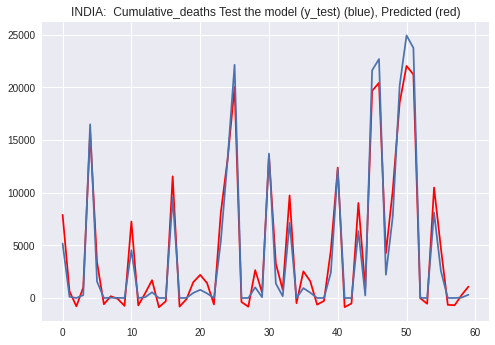

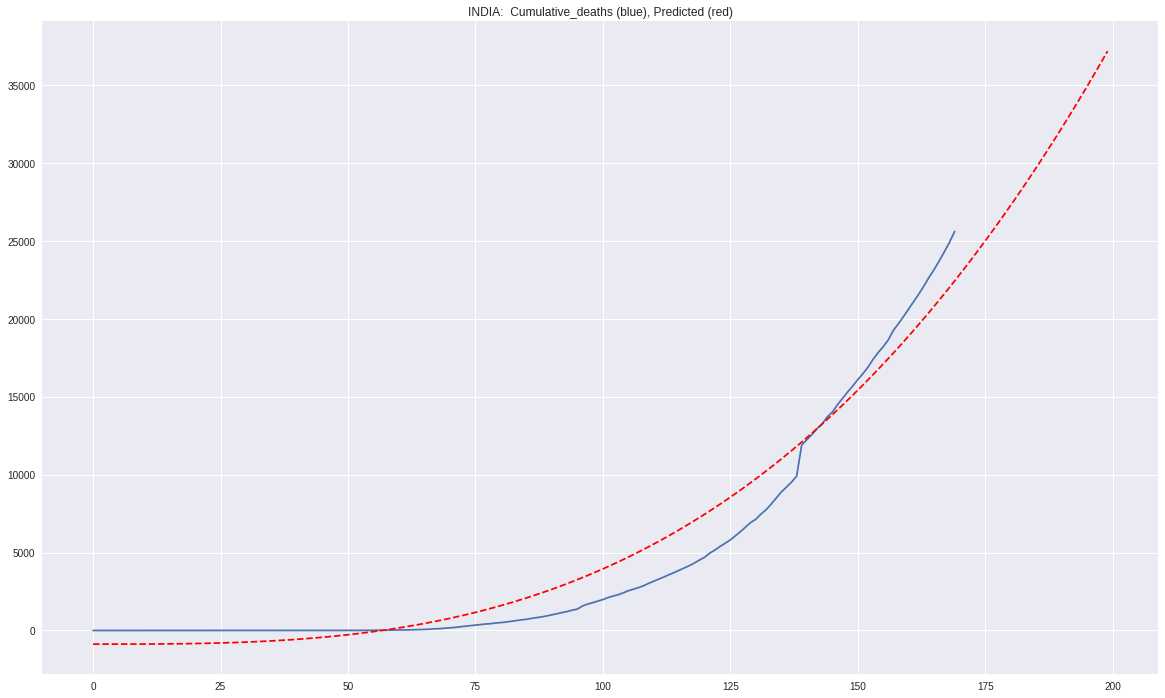

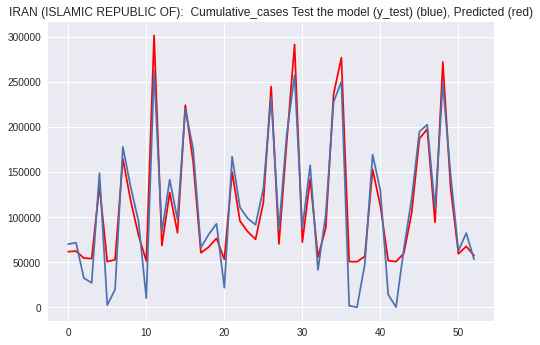

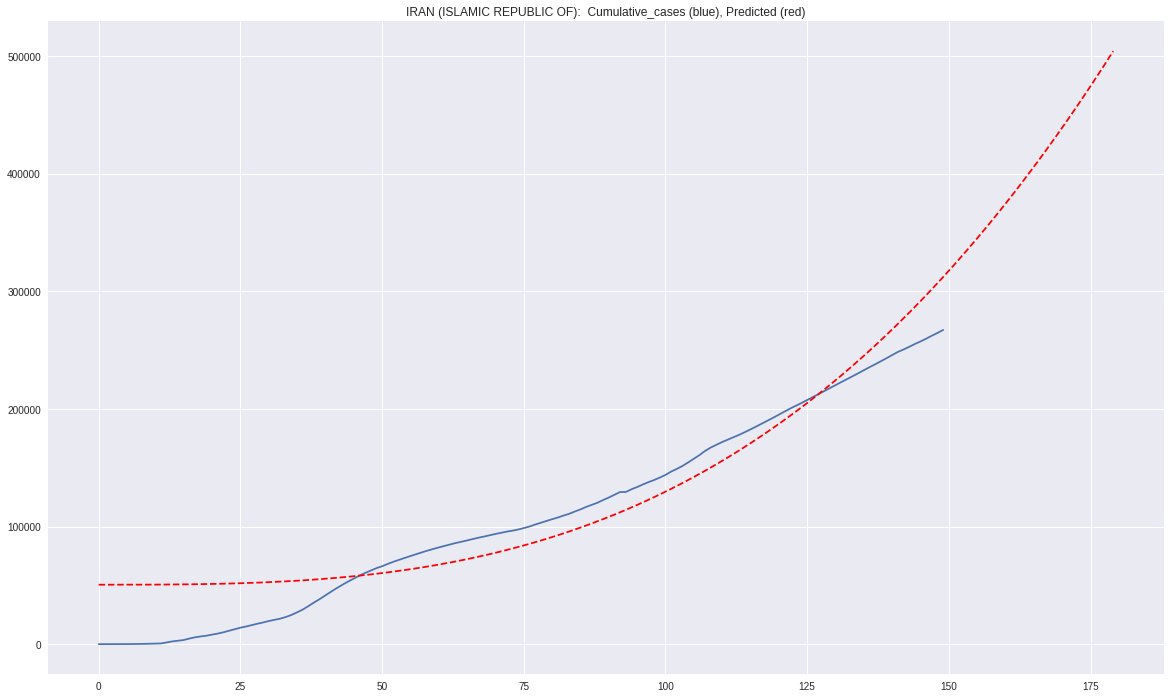

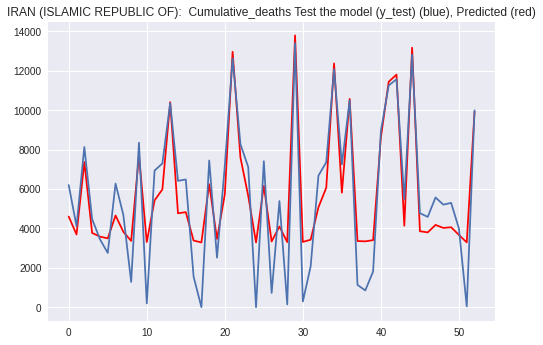

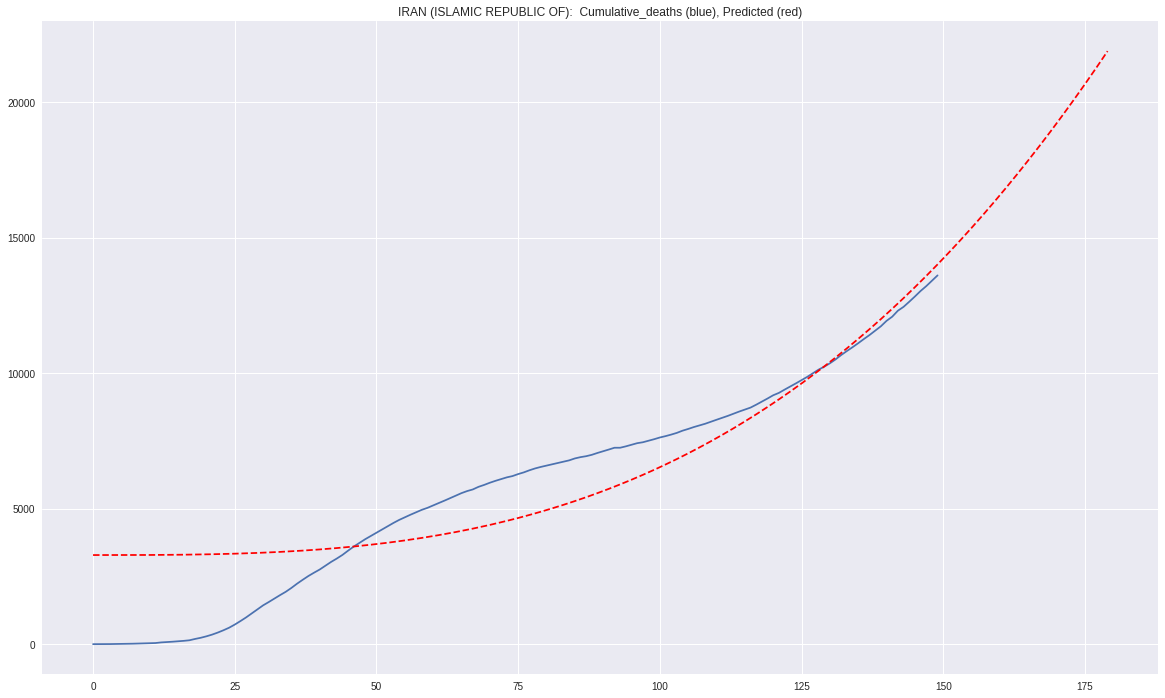

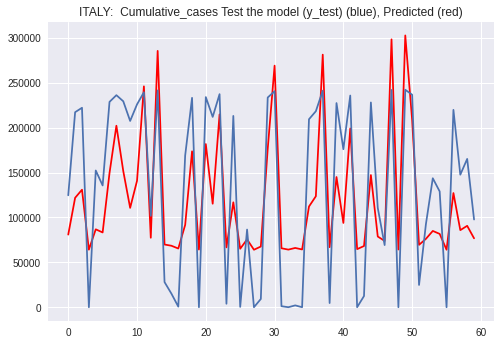

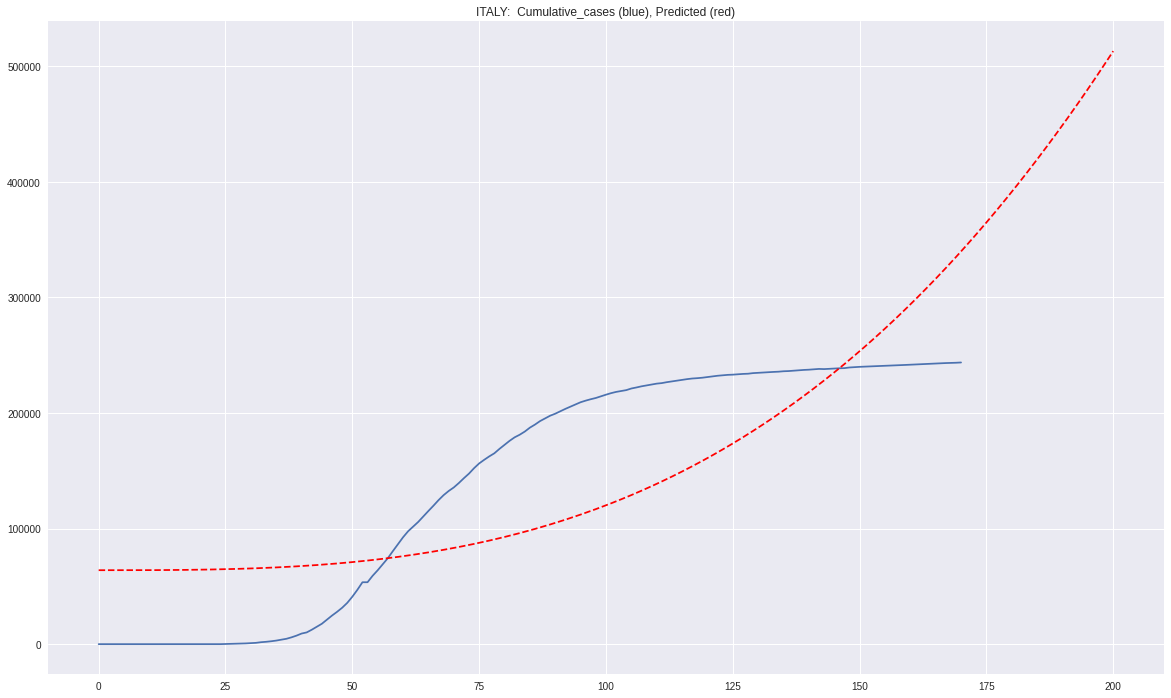

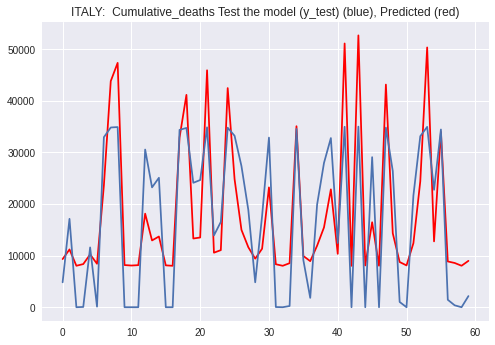

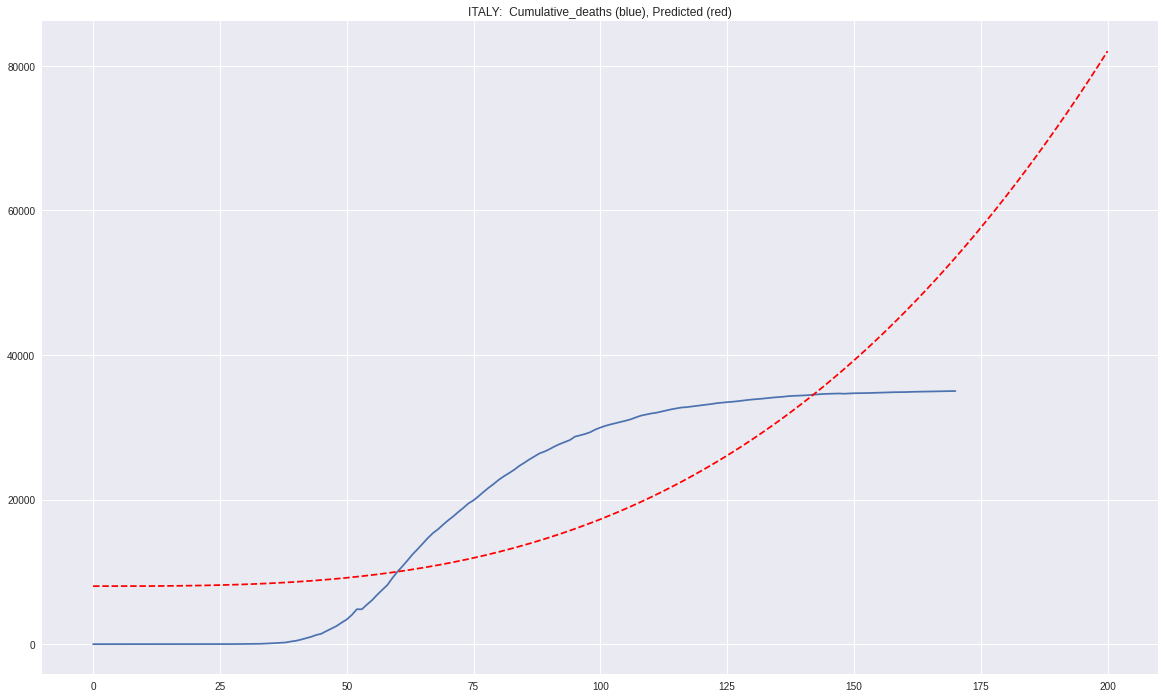

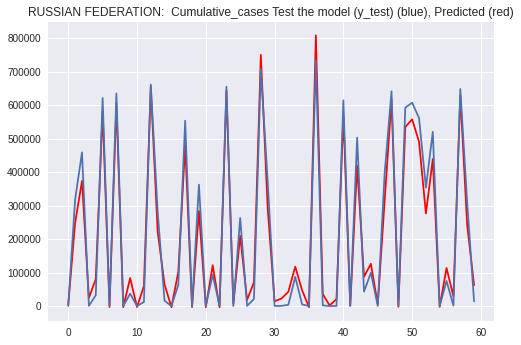

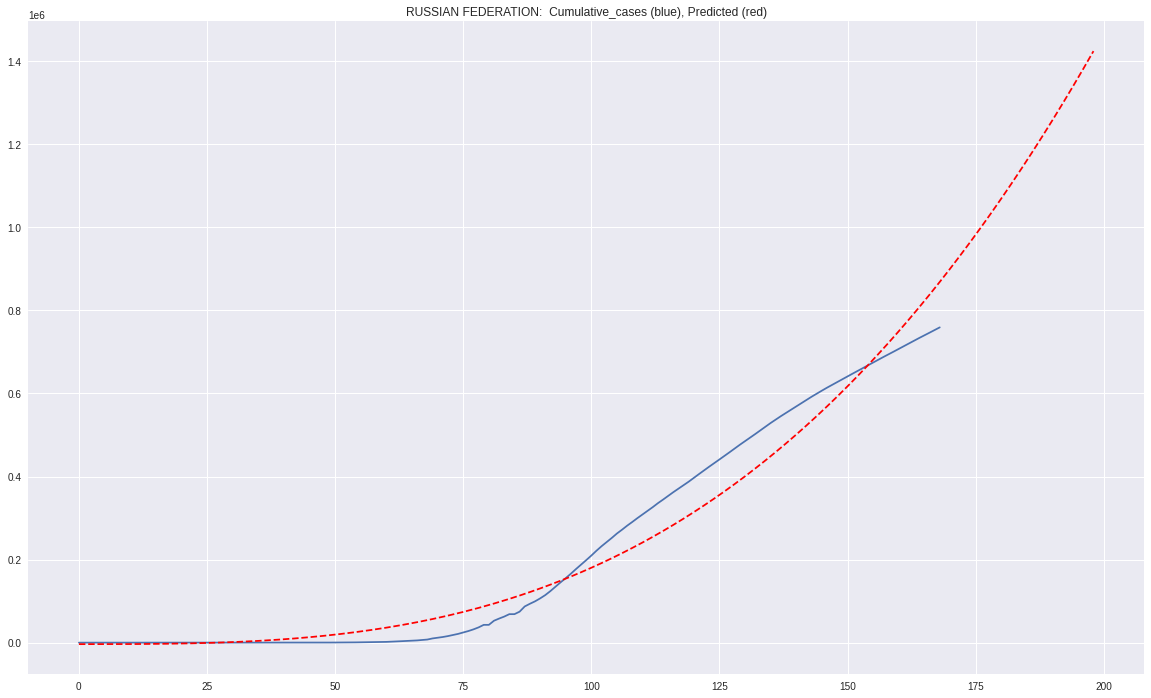

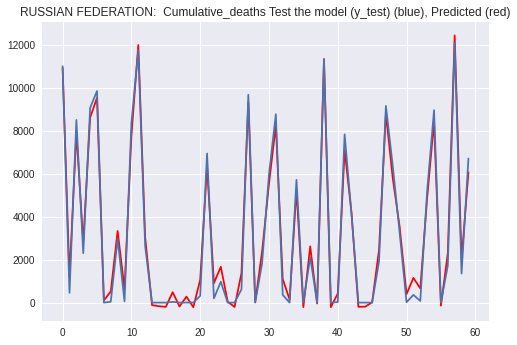

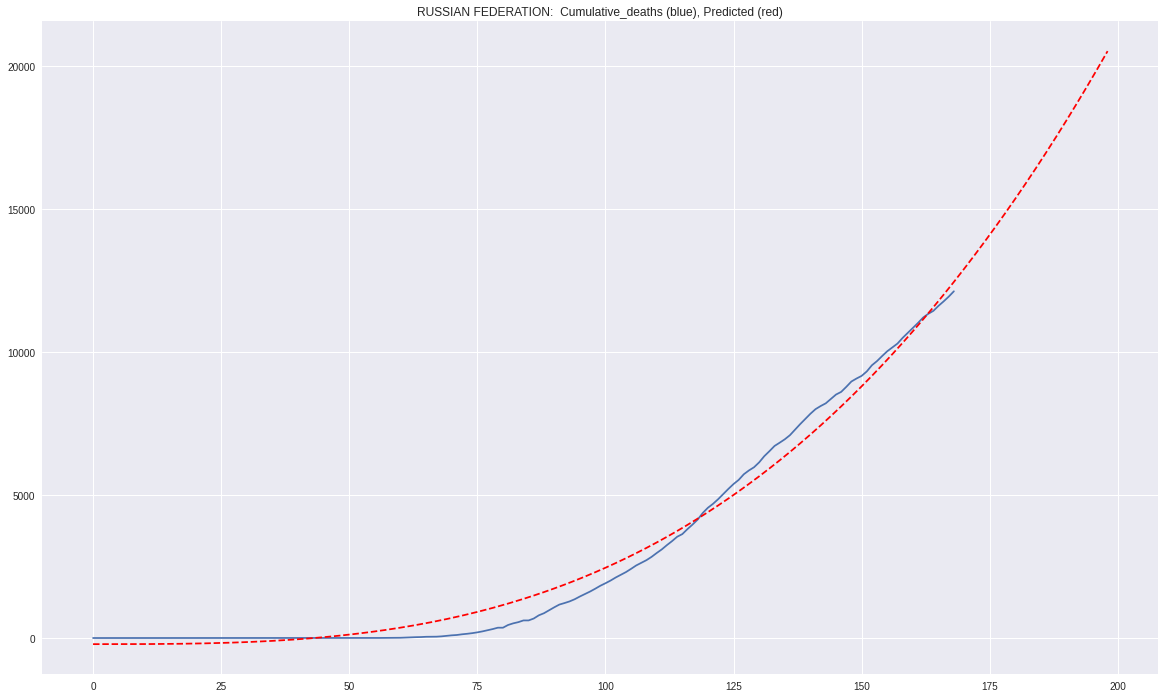

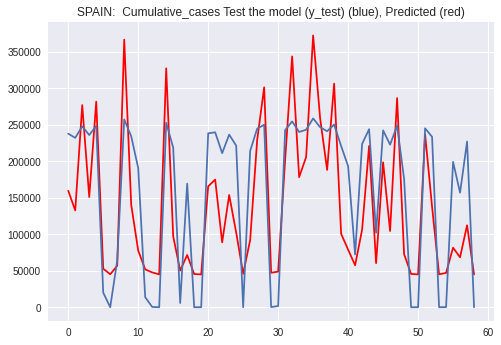

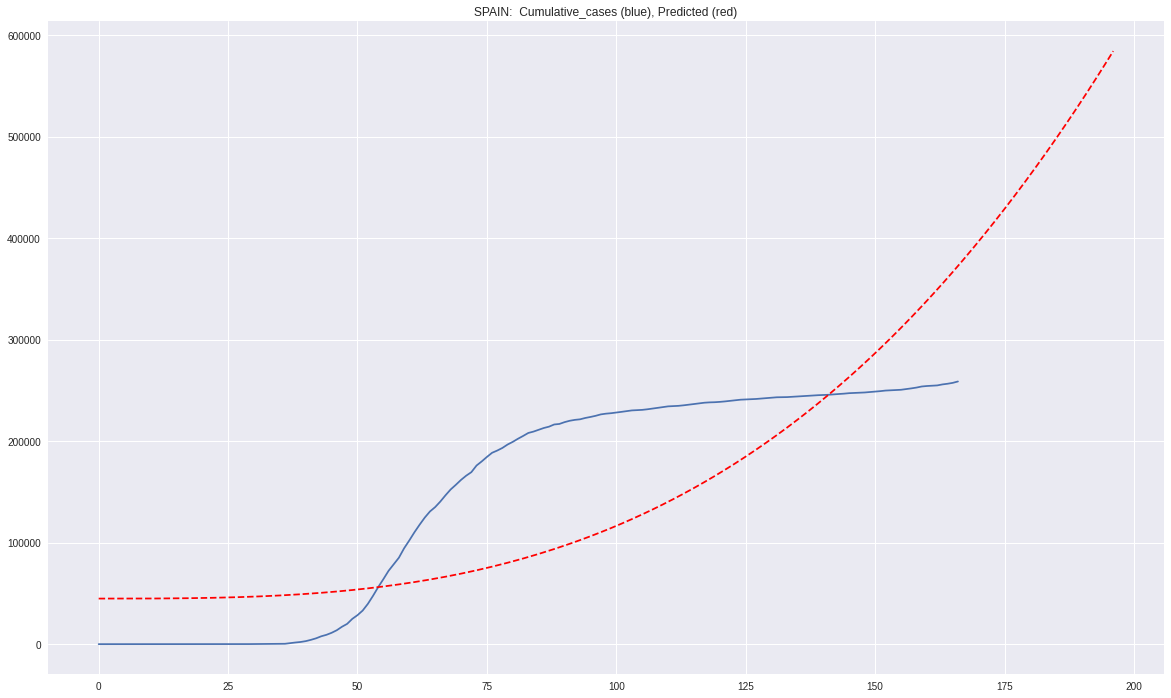

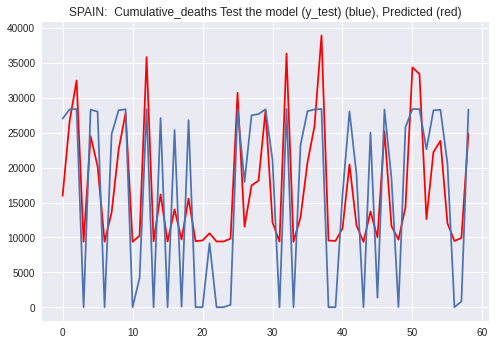

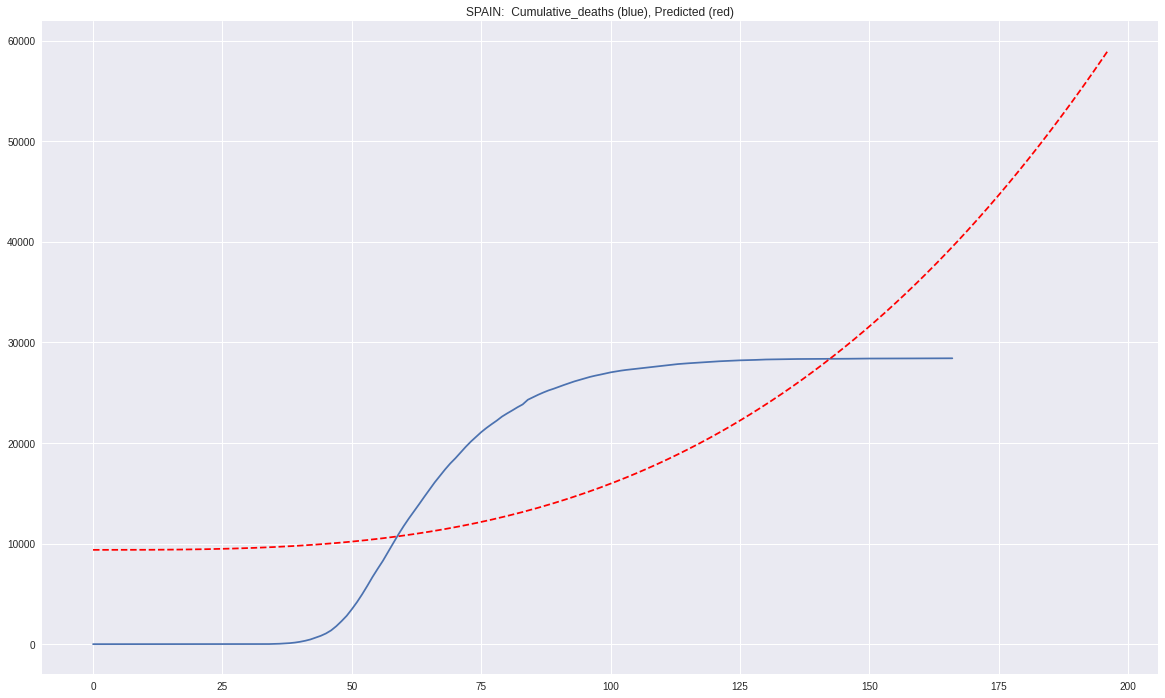

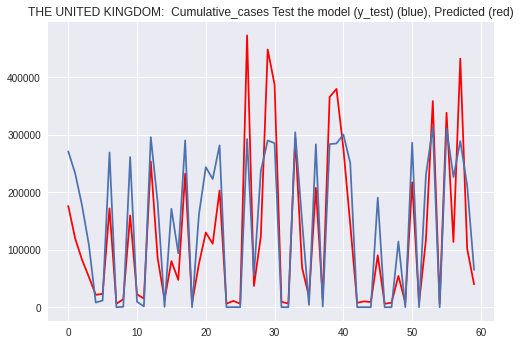

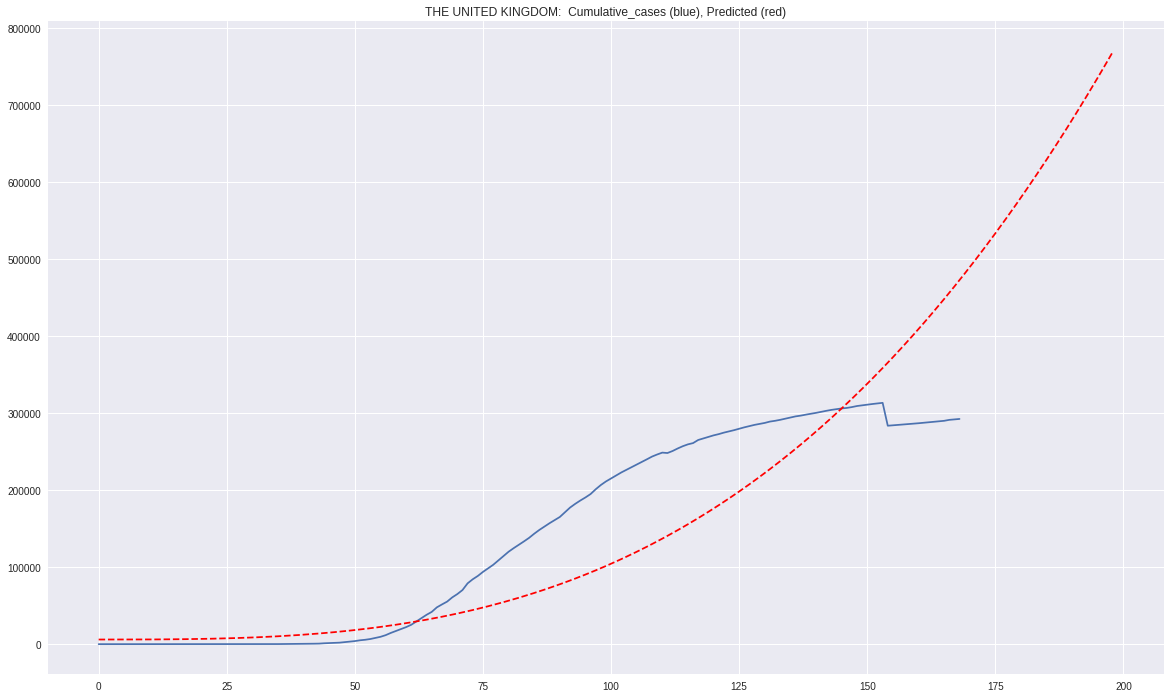

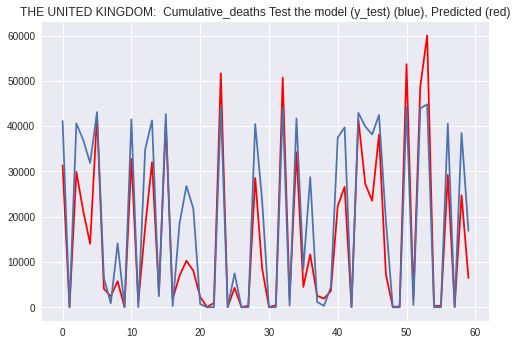

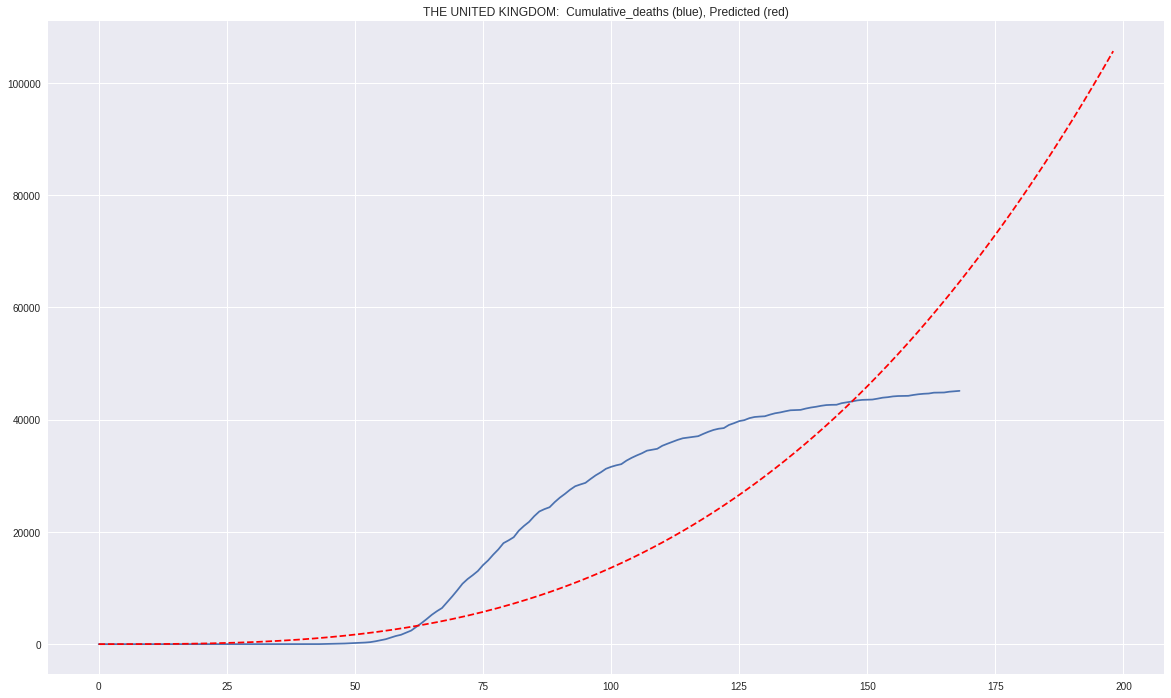

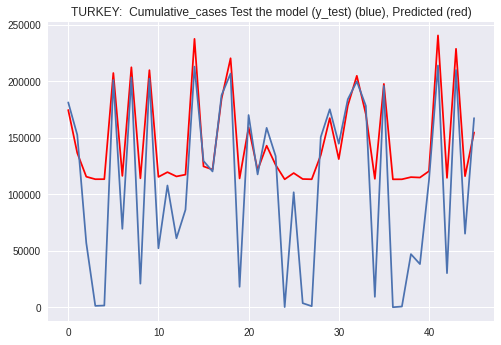

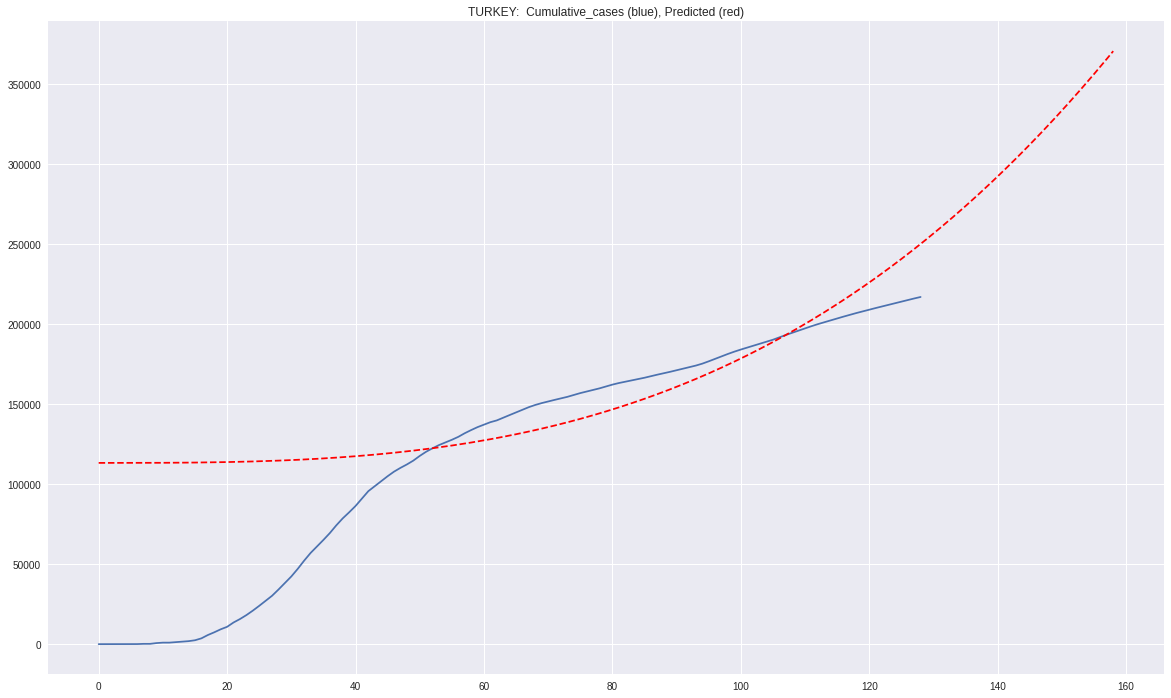

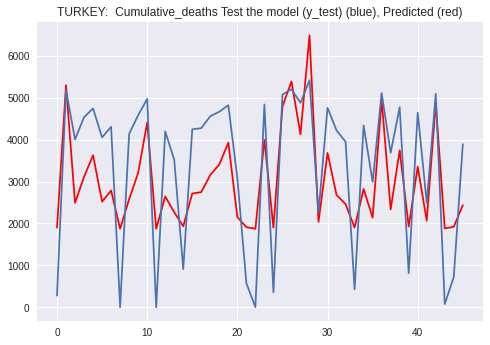

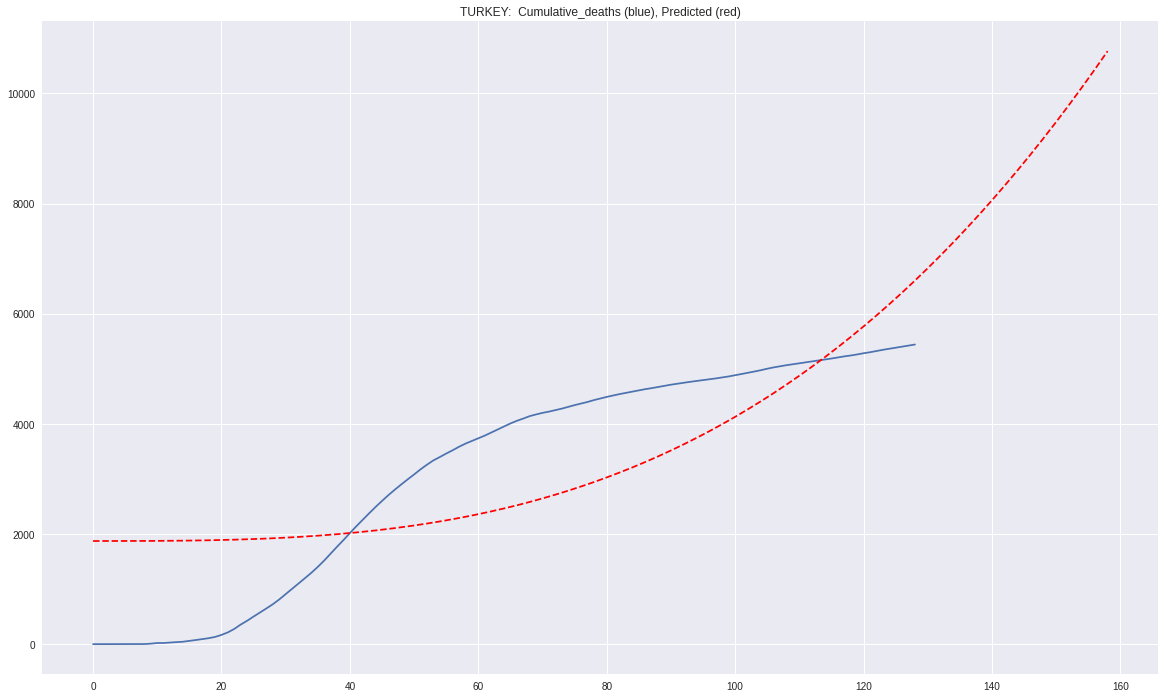

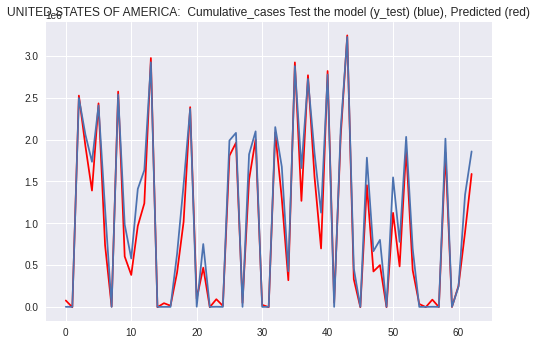

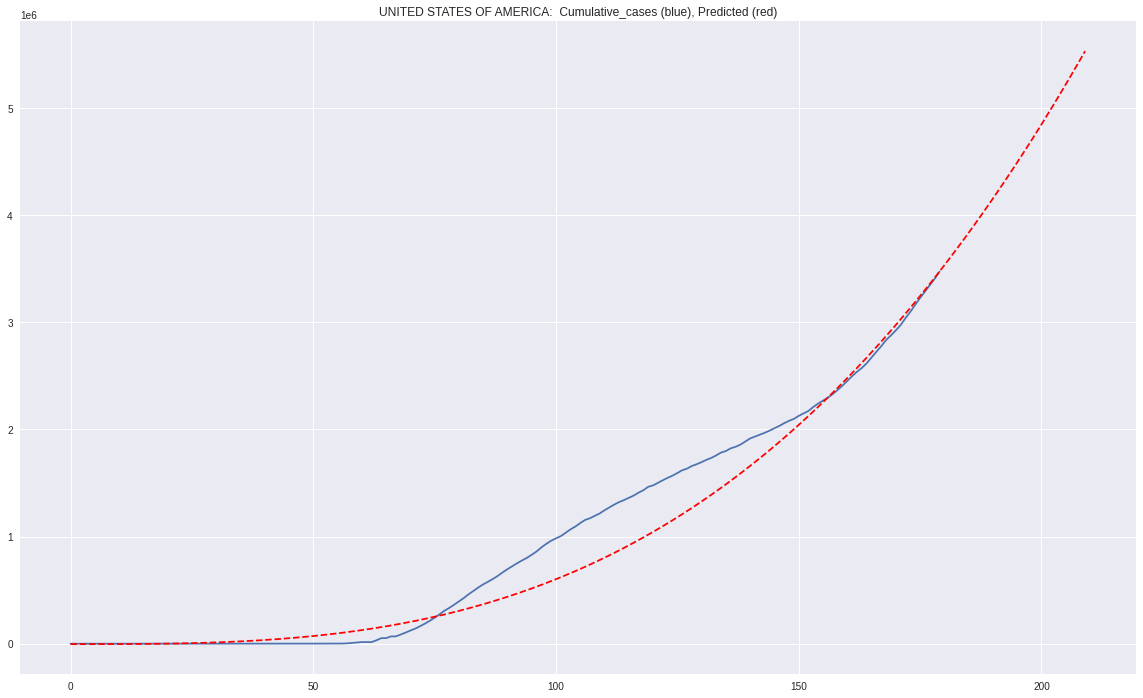

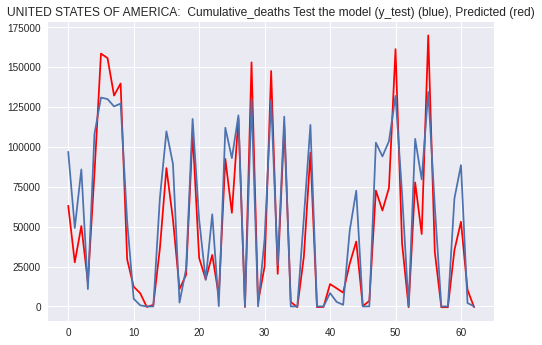

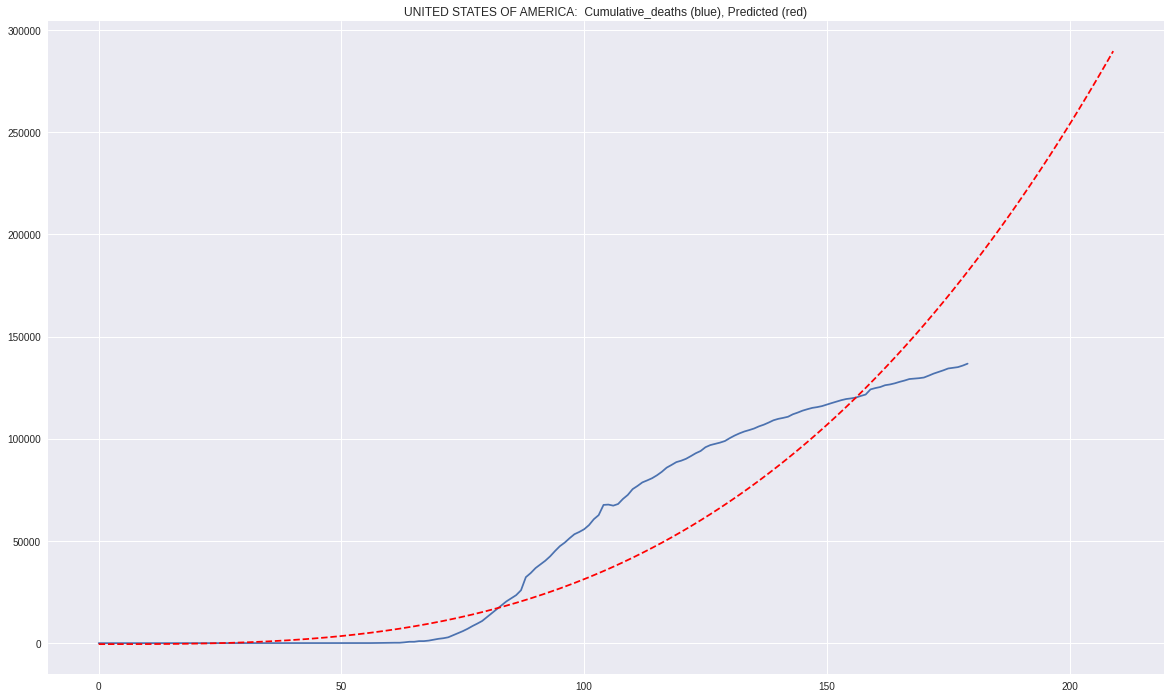

In [115]:
## LOOP THROUGH EACH COUNTRY
for country in worst_affected_countries:
    print(country)    
    df =who_data[who_data[' Country']==country].reset_index()
    df = df.drop(['index'], axis=1)
    Country = df[' Country'][0]
    Country_code =  df[' Country_code'][0]
    WHO_region = df[' WHO_region'][0]
    #add the 30 days
    df = df.append(pd.DataFrame({'Date_reported': pd.date_range(start=df['Date_reported'].iloc[-1], periods=31, freq='D', closed='right').date}))

    df = df.reset_index()
    df = df.drop(['index'], axis=1)

    df[' Country']      = Country
    df[' Country_code'] = Country_code
    df[' WHO_region']   = WHO_region
    pred_cumulative_cases   = one_country(country, ' Cumulative_cases')
    pred_cumulative_deaths  = one_country(country, ' Cumulative_deaths')
    # pred_new_cases          = one_country(country, ' New_cases')
    # pred_new_deaths         = one_country(country, ' New_deaths')
    
    df['PRED_CUMULATIVE_CASES'] = pred_cumulative_cases 
    df['PRED_CUMULATIVE_DEATHS'] = pred_cumulative_deaths 
    # df['PRED_NEW_CASES'] = pred_new_cases
    # df['PRED_NEW_DEATHS'] = pred_new_deaths


    with open('/Drive/My Drive/Colab Notebooks/COVID19/'+country+'.csv', 'w') as f:
      df.to_csv(f)
  
